# Using SPARK SQL Query Geospatial

Geospatial data obtained through mobile devices and IoT sensors has become ubiquitous in the past few years. This notebook is developed as a guide to showcase how Analytics Engine's Geospatial APIs can be used to obtain useful insights from such data. 
The data that we will use is made available by the New York City Taxi and Limousine Commission (NYC Taxicab Trips Data). It consists of taxicab trip pick-up and drop-off dates/times, pick-up and drop-off locations, trip distances, itemized fares, rate types, payment types, and driver-reported passenger counts. We will use data from the first week of December 2015 for analysis in this notebook. NYC Yellow Taxicab data for December 2015 can be downloaded from __[here](https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2015-12.csv)__ To get only December 2015 first week data from the downloaded file, simply run the following shell command: grep 2015-12-0[1-7] yellow_tripdata_2015-12.csv > yellow_tripdata_2015-12_week1.csv 

NYC Point of Interest data can be downloaded from __[here](https://data.cityofnewyork.us/City-Government/Points-Of-Interest/rxuy-2muj/data)__. 
Once the two datasets are available on IBM Cloud Object Storage, they can be used with this notebook. Please provide the dataset URL's as input parameters when running cell 4. 

The notebook uses PixieDust library for visualization.

In [1]:
import sys
!{sys.executable} -m pip install pixiedust

Waiting for a Spark session to start...
Spark Initialization Done! ApplicationId = app-20210311054015-0000
KERNEL_ID = ec12a460-7e07-4e00-9afa-51ae4e46e4ec
     |████████████████████████████████| 197 kB 17.3 MB/s eta 0:00:01
     |████████████████████████████████| 97 kB 3.1 MB/s  eta 0:00:01
     |████████████████████████████████| 61 kB 5.4 MB/s  eta 0:00:01
     |████████████████████████████████| 11.5 MB 27.1 MB/s eta 0:00:01
     |████████████████████████████████| 9.9 MB 34.6 MB/s eta 0:00:01
     |████████████████████████████████| 178 kB 72.7 MB/s eta 0:00:01
     |████████████████████████████████| 58 kB 3.4 MB/s  eta 0:00:01
     |████████████████████████████████| 137 kB 70.8 MB/s eta 0:00:01
     |████████████████████████████████| 147 kB 60.9 MB/s eta 0:00:01
     |████████████████████████████████| 227 kB 65.5 MB/s eta 0:00:01
     |████████████████████████████████| 1.1 MB 53.3 MB/s eta 0:00:01
     |████████████████████████████████| 15.3 MB 58.8 MB/s eta 0:00:01
     |███████████

In [3]:
from pyst import STContext
# Register STContext, which is the main entry point
stc = STContext(spark.sparkContext._gateway)

In [4]:
spark._jvm.org.apache.spark.sql.types.SqlGeometry.registerAll(spark._jsparkSession)

In [6]:
import pandas as pd
from pyspark.sql.types import *
from pixiedust.display import *


#df_data_1 = pd.read_csv('https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2015-12-week1.csv')
df_data_1 = pd.read_csv('/project_data/data_asset/yellow_tripdata_2015-12-week1.csv')
df_data_1.head()

Row(VendorID='2', tpep_pickup_datetime='2015-12-01 00:00:00', tpep_dropoff_datetime='2015-12-01 00:05:16', passenger_count='5', trip_distance='0.96', pickup_longitude='-73.979942321777300', pickup_latitude='40.765380859375', RatecodeID='1', store_and_fwd_flag='N', dropoff_longitude='-73.96630859375', dropoff_latitude='40.763088226318400', payment_type='1', fare_amount='5.5', extra='0.5', mta_tax='0.5', tip_amount='1', tolls_amount='0', improvement_surcharge='0.3', total_amount='7.8')

In [7]:
yellow_trip_schema = StructType([StructField('VendorID', StringType()),
                              StructField('tpep_pickup_datetime', StringType()),
                              StructField('tpep_dropoff_datetime', StringType()),
                              StructField('passenger_count', StringType()),
                              StructField('trip_distance', StringType()),
                              StructField('pickup_longitude', DoubleType()),
                              StructField('pickup_latitude', DoubleType()),
                              StructField('RatecodeID', StringType()),
                              StructField('store_and_fwd_flag', StringType()),
                              StructField('dropoff_longitude', DoubleType()),
                              StructField('dropoff_latitude', DoubleType()),
                              StructField('payment_type', StringType()),
                              StructField('fare_amount', StringType()),
                              StructField('extra', StringType()),
                              StructField('mta_tax', StringType()),
                              StructField('tip_amount', StringType()),
                              StructField('tolls_amount', StringType()),
                              StructField('improvement_surcharge', StringType()),
                              StructField('total_amount', StringType())])

In [10]:
yellow_taxi_df = spark.createDataFrame(df_data_1, yellow_trip_schema)

In [11]:
yellow_taxi_df.show(3)

+--------+--------------------+---------------------+---------------+-------------+-------------------+------------------+----------+------------------+-------------------+------------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|   pickup_longitude|   pickup_latitude|RatecodeID|store_and_fwd_flag|  dropoff_longitude|  dropoff_latitude|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|
+--------+--------------------+---------------------+---------------+-------------+-------------------+------------------+----------+------------------+-------------------+------------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+
|       2| 2015-12-01 00:00:00|  2015-12-01 00:05:16|              5|         0.96|-73.979942321777300|   40.765380859375|        

In [12]:
yellow_taxi_df.createOrReplaceTempView("yellowtaxi")
yellow_taxi_df = spark.sql("SELECT *, ST_Point(pickup_longitude, pickup_latitude) as pickuplocation from yellowtaxi")
yellow_taxi_df.show(3)

+--------+--------------------+---------------------+---------------+-------------+-------------------+------------------+----------+------------------+-------------------+------------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|   pickup_longitude|   pickup_latitude|RatecodeID|store_and_fwd_flag|  dropoff_longitude|  dropoff_latitude|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|      pickuplocation|
+--------+--------------------+---------------------+---------------+-------------+-------------------+------------------+----------+------------------+-------------------+------------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+
|       2| 2015-12-01 00:00:00|  2015-12-01 00:05:16|              

In [13]:
top_pickup_df = spark.sql("""SELECT avg(PASSENGER_COUNT), avg(TRIP_DISTANCE), avg(FARE_AMOUNT), avg(TIP_AMOUNT),
ST_X(ST_BoundingBoxCenter(ST_Envelope(ST_GeohashDecode(geohash)))) AS lon, ST_Y(ST_BoundingBoxCenter(ST_Envelope(ST_GeohashDecode(geohash)))) AS lat,
count(*) AS COUNT FROM (SELECT PASSENGER_COUNT,TRIP_DISTANCE,FARE_AMOUNT, TIP_AMOUNT, cast(ST_ContainingGeohash(ST_Point(PICKUP_LONGITUDE, PICKUP_LATITUDE), 300)
AS string) AS geohash FROM yellowtaxi WHERE PICKUP_LONGITUDE < -60 AND PICKUP_LATITUDE > 30 AND DROPOFF_LONGITUDE != PICKUP_LONGITUDE 
AND DROPOFF_LATITUDE != PICKUP_LATITUDE) GROUP BY geohash ORDER BY COUNT DESC LIMIT 50""")

In [14]:
top_pickup_df.show(3)

+------------------------------------+----------------------------------+--------------------------------+-------------------------------+---------------+--------------+-----+
|avg(CAST(PASSENGER_COUNT AS DOUBLE))|avg(CAST(TRIP_DISTANCE AS DOUBLE))|avg(CAST(FARE_AMOUNT AS DOUBLE))|avg(CAST(TIP_AMOUNT AS DOUBLE))|            lon|           lat|COUNT|
+------------------------------------+----------------------------------+--------------------------------+-------------------------------+---------------+--------------+-----+
|                   1.756198347107438|                2.1574380165289258|              11.760330578512397|             1.6454545454545446|-73.98193359375|40.75927734375|  242|
|                   1.778301886792453|                 2.270188679245283|               11.36320754716981|             1.6064150943396234|   -74.00390625|  40.693359375|  212|
|                  1.8819444444444444|                 1.966458333333333|              10.225694444444445|             1

In [15]:
if isinstance(top_pickup_df, str):
    print(top_pickup_df)

In [16]:
display(top_pickup_df)

In [17]:
top_dropoff_df = spark.sql("""SELECT avg(PASSENGER_COUNT), avg(TRIP_DISTANCE), avg(FARE_AMOUNT), avg(TIP_AMOUNT),
                           ST_X(ST_BoundingBoxCenter(ST_Envelope(ST_GeohashDecode(geohash)))) AS lon,
                           ST_Y(ST_BoundingBoxCenter(ST_Envelope(ST_GeohashDecode(geohash)))) AS lat,count(*) AS COUNT 
                           FROM (SELECT PASSENGER_COUNT,TRIP_DISTANCE,FARE_AMOUNT, TIP_AMOUNT, 
                           cast(ST_ContainingGeohash(ST_Point(DROPOFF_LONGITUDE, DROPOFF_LATITUDE), 300) AS string) AS geohash
                           FROM yellowtaxi WHERE DROPOFF_LONGITUDE < -60 AND DROPOFF_LATITUDE > 30 AND DROPOFF_LONGITUDE != PICKUP_LONGITUDE 
                           AND DROPOFF_LATITUDE != PICKUP_LATITUDE) GROUP BY geohash ORDER BY COUNT DESC LIMIT 50""")

In [18]:
top_dropoff_df.show(3)

+------------------------------------+----------------------------------+--------------------------------+-------------------------------+---------------+--------------+-----+
|avg(CAST(PASSENGER_COUNT AS DOUBLE))|avg(CAST(TRIP_DISTANCE AS DOUBLE))|avg(CAST(FARE_AMOUNT AS DOUBLE))|avg(CAST(TIP_AMOUNT AS DOUBLE))|            lon|           lat|COUNT|
+------------------------------------+----------------------------------+--------------------------------+-------------------------------+---------------+--------------+-----+
|                  1.9023255813953488|                2.7479534883720933|               14.23953488372093|              1.517720930232558|-73.98193359375|40.75927734375|  215|
|                  1.6243654822335025|                 2.812893401015227|              13.121827411167512|             1.9857868020304565|   -74.00390625|  40.693359375|  197|
|                  1.6533333333333333|                1.8573999999999997|                            9.99|             1

In [19]:
if isinstance(top_dropoff_df, str):
    print(top_dropoff_df)

In [20]:
display(top_dropoff_df)

In [21]:
weekday_morning_dropoffs = spark.sql("""select ST_X(ST_BoundingBoxCenter(ST_Envelope(ST_GeohashDecode(geohash)))) as lon, 
ST_Y(ST_BoundingBoxCenter(ST_Envelope(ST_GeohashDecode(geohash)))) as lat, count(*) as count from 
(select cast(ST_ContainingGeohash(ST_Point(DROPOFF_LONGITUDE, DROPOFF_LATITUDE), 100) as string) as geohash from 
yellowtaxi where cast(tpep_dropoff_datetime as date) BETWEEN cast('2015-12-01' as date) and cast('2015-12-04' as date)
and hour(tpep_dropoff_datetime) between 6 and 19 AND DROPOFF_LONGITUDE < 0 AND DROPOFF_LATITUDE > 0 AND
DROPOFF_LONGITUDE != PICKUP_LONGITUDE AND DROPOFF_LATITUDE != PICKUP_LATITUDE) GROUP BY geohash ORDER BY count
DESC LIMIT 50""")

In [22]:
weekday_morning_dropoffs.show(4)

+---------------+---------------+-----+
|            lon|            lat|count|
+---------------+---------------+-----+
|-73.98193359375| 40.75927734375|   70|
|   -74.00390625|   40.693359375|   69|
|-73.98193359375|40.770263671875|   65|
| -73.9599609375| 40.75927734375|   50|
+---------------+---------------+-----+
only showing top 4 rows



In [23]:
if isinstance(weekday_morning_dropoffs, str):
    print(weekday_morning_dropoffs)

In [ ]:
display(weekday_morning_dropoffs)

In [25]:
weekday_morning_hour_histogram = spark.sql("""
select hour(tpep_dropoff_datetime), count(*) from yellowtaxi where cast(tpep_dropoff_datetime as date) BETWEEN cast('2015-12-01' as date) and cast('2015-12-04' as date)
and hour(tpep_dropoff_datetime) between 6 and 19 AND DROPOFF_LONGITUDE < 0 AND DROPOFF_LATITUDE > 0 AND
DROPOFF_LONGITUDE != PICKUP_LONGITUDE AND DROPOFF_LATITUDE != PICKUP_LATITUDE group by hour(tpep_dropoff_datetime)
""")

In [26]:
weekday_morning_hour_histogram.show()

+----------------------------------------------+--------+
|hour(CAST(tpep_dropoff_datetime AS TIMESTAMP))|count(1)|
+----------------------------------------------+--------+
|                                            19|    1521|
|                                            17|     190|
|                                            18|      49|
+----------------------------------------------+--------+



In [27]:
if isinstance(weekday_morning_hour_histogram, str):
    print(weekday_morning_hour_histogram)


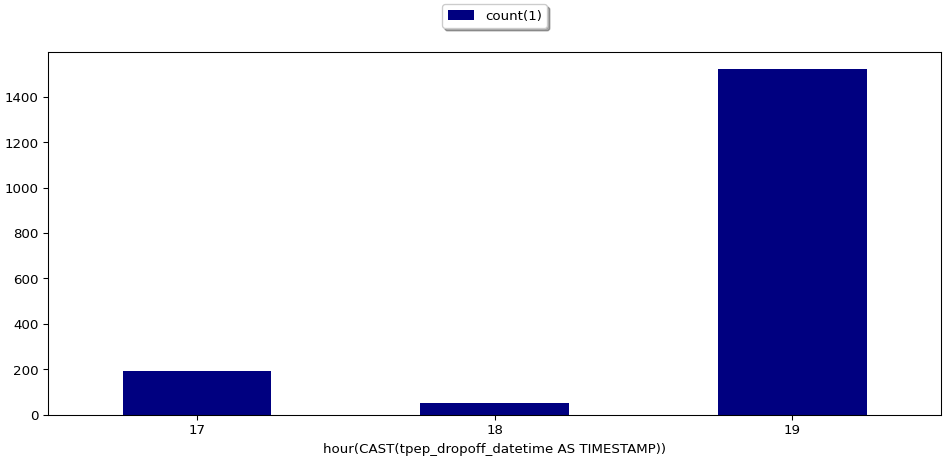

In [ ]:
display(weekday_morning_hour_histogram)

In [29]:
popular_weekend_spots = spark.sql("""
select ST_X(ST_BoundingBoxCenter(ST_Envelope(ST_GeohashDecode(geohash)))) as lon,
ST_Y(ST_BoundingBoxCenter(ST_Envelope(ST_GeohashDecode(geohash)))) as lat, count(*) as count
from (select cast(ST_ContainingGeohash(ST_Point(PICKUP_LONGITUDE, PICKUP_LATITUDE), 100) as string)
as geohash from yellowtaxi where cast(tpep_dropoff_datetime as date) BETWEEN cast('2015-12-01' as date) and cast('2015-12-04' as date)
and (hour(tpep_pickup_datetime) > 20 or hour(tpep_pickup_datetime) < 6) AND PICKUP_LONGITUDE < 0 AND PICKUP_LATITUDE > 0 AND
DROPOFF_LONGITUDE != PICKUP_LONGITUDE AND DROPOFF_LATITUDE != PICKUP_LATITUDE) GROUP BY geohash ORDER BY count
DESC LIMIT 50
""")

In [30]:
popular_weekend_spots.show()

+------------------+-----------------+-----+
|               lon|              lat|count|
+------------------+-----------------+-----+
|   -73.98193359375|   40.75927734375|   10|
|  -73.861083984375|  40.770263671875|    7|
|    -73.8720703125|   40.75927734375|    7|
|      -74.00390625|     40.693359375|    7|
|-73.87481689453125|40.77301025390625|    5|
|   -73.98193359375|  40.770263671875|    5|
|  -73.992919921875| 40.7537841796875|    4|
|    -73.9599609375|    40.7373046875|    4|
|  -73.970947265625| 40.7537841796875|    4|
| -73.7786865234375| 40.6439208984375|    4|
| -73.9984130859375| 40.7427978515625|    3|
|  -73.992919921875| 40.7427978515625|    3|
| -73.9764404296875|40.75653076171875|    3|
| -73.9874267578125| 40.7647705078125|    3|
|   -73.98193359375|  40.748291015625|    3|
| -73.9874267578125| 40.7537841796875|    3|
|  -73.992919921875| 40.7318115234375|    3|
| -73.7896728515625|40.64666748046875|    3|
| -73.9764404296875| 40.6768798828125|    2|
|-73.99017

In [31]:
if isinstance(popular_weekend_spots, str):
    print(popular_weekend_spots)

In [ ]:
display(popular_weekend_spots)

In [33]:
weekend_night_hour_histogram = spark.sql("""
select hour(tpep_pickup_datetime), count(*) from yellowtaxi where cast(tpep_dropoff_datetime as date) BETWEEN cast('2015-12-01' as date) and cast('2015-12-06' as date)
and (hour(tpep_pickup_datetime) > 20 or hour(tpep_pickup_datetime) < 6) AND PICKUP_LONGITUDE < 0 AND PICKUP_LATITUDE > 0 AND
DROPOFF_LONGITUDE != PICKUP_LONGITUDE AND DROPOFF_LATITUDE != PICKUP_LATITUDE group by hour(tpep_pickup_datetime)
""")

In [34]:
weekend_night_hour_histogram.show()

+---------------------------------------------+--------+
|hour(CAST(tpep_pickup_datetime AS TIMESTAMP))|count(1)|
+---------------------------------------------+--------+
|                                            0|     170|
+---------------------------------------------+--------+



In [35]:
if isinstance(weekend_night_hour_histogram, str):
    print(weekend_night_hour_histogram)


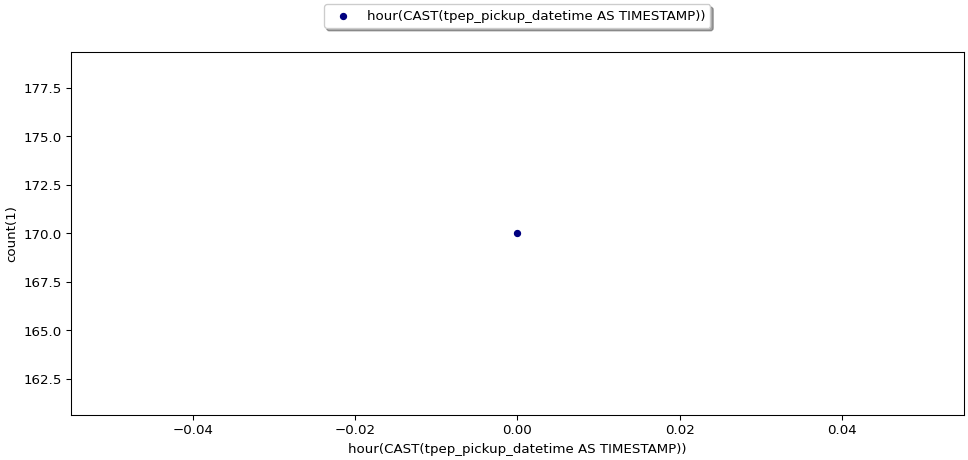

In [36]:
display(weekend_night_hour_histogram)

In [37]:
top_tip_neighborhoods = spark.sql("""
SELECT AVG(TIP_AMOUNT), ST_X(ST_BoundingBoxCenter(ST_Envelope(ST_GeohashDecode(geohash)))) as lon,
ST_Y(ST_BoundingBoxCenter(ST_Envelope(ST_GeohashDecode(geohash)))) as lat, count(*) as count FROM (SELECT PASSENGER_COUNT, TRIP_DISTANCE, FARE_AMOUNT, TIP_AMOUNT,
cast(ST_ContainingGeohash(ST_Point(DROPOFF_LONGITUDE, DROPOFF_LATITUDE), 0) as string) as geohash FROM yellowtaxi WHERE DROPOFF_LONGITUDE < 0 AND DROPOFF_LATITUDE > 0 AND 
DROPOFF_LONGITUDE != PICKUP_LONGITUDE AND DROPOFF_LATITUDE != PICKUP_LATITUDE) GROUP BY geohash ORDER BY AVG(TIP_AMOUNT)
DESC LIMIT 50
""")

In [38]:
top_tip_neighborhoods.show()

+-------------------------------+-----------------+----------------+-----+
|avg(CAST(TIP_AMOUNT AS DOUBLE))|              lon|             lat|count|
+-------------------------------+-----------------+----------------+-----+
|                          19.07|-74.2017288208008|40.5239753723145|    1|
|                          17.21|-74.1784057617188|40.6896514892578|    1|
|                          16.45|-73.5934753417969|40.6384048461914|    1|
|                           16.0|-74.0200271606445|40.7716674804688|    1|
|                          15.25|-73.9931335449219|40.7628402709961|    1|
|                          14.58|-73.9796752929688|40.7655334472656|    1|
|                           14.0|-74.1643295288086|40.8724174499512|    1|
|                          13.59|-73.7854690551758| 40.739013671875|    1|
|                           13.0|-73.9795532226563|40.7887382507324|    1|
|                          12.08|   -73.9541015625|40.7471733093262|    1|
|                        

In [39]:
if isinstance(top_tip_neighborhoods, str):
    print(top_tip_neighborhoods)

In [40]:
display(top_tip_neighborhoods)

In [41]:
#df_data_2 = pd.read_csv('/project_data/data_asset/Point_Of_Interest.csv')
#df_data_2.head()
import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.

if os.environ.get('RUNTIME_ENV_LOCATION_TYPE') == 'external':
    endpoint_ad960f8ef6564ff288b52be6f0acd428 = 'https://s3-api.us-geo.objectstorage.softlayer.net'
else:
    endpoint_ad960f8ef6564ff288b52be6f0acd428 = 'https://s3-api.us-geo.objectstorage.service.networklayer.com'

client_ad960f8ef6564ff288b52be6f0acd428 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='7cT7c4qjCsIj8gghXXs-KDqnJloefFQn4rwB4UYLYIrG',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url=endpoint_ad960f8ef6564ff288b52be6f0acd428)

body = client_ad960f8ef6564ff288b52be6f0acd428.get_object(Bucket='rachittest-donotdelete-pr-iuj2urmwt3ly0j',Key='Point_Of_Interest.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data_2 = pd.read_csv(body)
df_data_2.head()


,SAFTYPE,COMPLEXID,the_geom,SEGMENTID,SOS,PLACEID,FACI_DOM,BIN,BOROUGH,CREATED,MODIFIED,FACILITY_T,SOURCE,B7SC,PRI_ADD,NAME
0,N,401,POINT (-73.93149397004032 40.84419199998088),193927,1.0,1031153,8,0,1.0,04/12/2018 12:00:00 AM +0000,03/12/2020 12:00:00 AM +0000,6,DCP,11095502.0,0,HRD RAMP TO GWB OVER HRD SB
1,N,0,POINT (-74.196729991945 40.63526107028508),321726,1.0,19954,8,0,5.0,03/15/2008 12:00:00 AM +0000,03/16/2020 12:00:00 AM +0000,6,DCP,59703501.0,0,GOETHALS
2,N,0,POINT (-73.9580216105277 40.75848681229432),138896,1.0,1026908,8,0,1.0,10/20/2015 12:00:00 AM +0000,03/16/2020 12:00:00 AM +0000,6,DoITT,19792015.0,0,KOCH BR PEDESTRIAN AND BIKE PATH
3,N,0,POINT (-73.95061614358269 40.755299567687125),139388,1.0,1026909,8,0,4.0,10/20/2015 12:00:00 AM +0000,03/16/2020 12:00:00 AM +0000,6,DoITT,49734017.0,0,KOCH BR PEDESTRIAN AND BIKE
4,N,0,POINT (-73.81678346994171 40.78815244048363),179357,2.0,1031297,8,0,4.0,04/13/2018 12:00:00 AM +0000,04/19/2018 12:00:00 AM +0000,6,DCP,40074101.0,0,14 AV OV BELT CROSS ISL PKWY


In [42]:
point_of_interest_schema = StructType([StructField('SAFTYPE', StringType()),
                              StructField('COMPLEXID', StringType()),
                              StructField('the_geom', StringType()),
                              StructField('SEGMENTID', StringType()),
                              StructField('SOS', StringType()),
                              StructField('PLACEID', StringType()),
                              StructField('FACI_DOM', StringType()),
                              StructField('BIN', StringType()),
                              StructField('BOROUGH', StringType()),
                              StructField('CREATED', StringType()),
                              StructField('MODIFIED', StringType()),
                              StructField('FACILITY_T', StringType()),
                              StructField('SOURCE', StringType()),
                              StructField('B7SC', StringType()),
                              StructField('PRI_ADD', StringType()),
                              StructField('NAME', StringType()),
                              ])

In [43]:
point_of_interest_df = spark.createDataFrame(df_data_2, point_of_interest_schema)

In [44]:
point_of_interest_df.createOrReplaceTempView("pointofinterest")

In [45]:
top_visited_from_gct = spark.sql("""
select NAME from (select NAME,cast(ST_ContainingGeohash(ST_WKTToSQL(THE_GEOM),10) as string) as hash1
from pointofinterest ) as geohash1,
(select cast(ST_ContainingGeohash(ST_Point(DROPOFF_LONGITUDE,DROPOFF_LATITUDE),10) as string) as hash2
from yellowtaxi,(SELECT ST_WKTToSQL('POLYGON((-73.9741470452658 40.754053521967954,-73.9775158997885 40.75528885933616,-73.9796402093283 40.75228174804338,-73.97974749768889 40.752167962783425,-73.97659321988738 40.75078626908878,-73.9741470452658 40.754053521967954))') as GCT) WHERE PICKUP_LONGITUDE < 0 AND PICKUP_LATITUDE > 0
AND DROPOFF_LONGITUDE < 0 AND DROPOFF_LATITUDE > 0 AND DROPOFF_LONGITUDE != PICKUP_LONGITUDE AND DROPOFF_LATITUDE != PICKUP_LATITUDE AND
ST_Contains(GCT, ST_POINT(PICKUP_LONGITUDE, PICKUP_LATITUDE))) as geohash2
where geohash1.hash1=geohash2.hash2 group by name order by count(*) DESC LIMIT 50
""")

In [46]:
top_visited_from_gct.show(3)

+----+
|NAME|
+----+
+----+



In [47]:
if isinstance(top_visited_from_gct, str):
    print(top_visited_from_gct)

In [48]:
display(top_visited_from_gct)

NAME


In [49]:
jfk_trip_times_df = spark.sql("""
select AVG(UNIX_TIMESTAMP(tpep_dropoff_datetime,'yyyy-MM-dd HH:mm:ss.SSS') - UNIX_TIMESTAMP(tpep_pickup_datetime,'yyyy-MM-dd HH:mm:ss.SSS'))/3600 as trip_time,
ST_X(ST_BoundingBoxCenter(ST_Envelope(ST_GeohashDecode(geohash)))) as lon,ST_Y(ST_BoundingBoxCenter(ST_Envelope(ST_GeohashDecode(geohash)))) as lat FROM
(SELECT tpep_pickup_datetime, tpep_dropoff_datetime, cast(ST_ContainingGeohash(ST_Point(PICKUP_LONGITUDE, PICKUP_LATITUDE), 300) as string) as geohash FROM yellowtaxi,(SELECT ST_WKTToSQL('POLYGON((-73.79842758178711 40.666888357414656,-73.82160186767578 40.66128921909981,-73.82589340209961 40.65191286531297,-73.8174819946289 40.6443587331021,-73.78314971923828 40.62963874385982,-73.7735366821289 40.62364560634639,-73.75551223754883 40.6312020825878,-73.7350845336914 40.63667347990595,-73.7460708618164 40.64995929240809,-73.76890182495117 40.66141943695725,-73.79842758178711 40.666888357414656))') as JFK)
WHERE 
ST_Contains(JFK, ST_Point(DROPOFF_LONGITUDE, DROPOFF_LATITUDE))
AND PICKUP_LONGITUDE < 0 AND PICKUP_LATITUDE > 0 AND DROPOFF_LONGITUDE != PICKUP_LONGITUDE AND DROPOFF_LATITUDE != PICKUP_LATITUDE) GROUP BY geohash ORDER BY trip_time DESC
""")

In [50]:
jfk_trip_times_df.show(3)

+---------+---+---+
|trip_time|lon|lat|
+---------+---+---+
+---------+---+---+



In [51]:
if isinstance(jfk_trip_times_df, str):
    print(jfk_trip_times_df)

In [52]:
display(jfk_trip_times_df)

In [53]:
jfk_trip_times_by_hour_df = spark.sql("""
select hour(tpep_dropoff_datetime), AVG(UNIX_TIMESTAMP(tpep_dropoff_datetime,'yyyy-MM-dd HH:mm:ss.SSS') - UNIX_TIMESTAMP(tpep_pickup_datetime,'yyyy-MM-dd HH:mm:ss.SSS'))/3600 as trip_time
FROM (SELECT tpep_pickup_datetime, tpep_dropoff_datetime FROM yellowtaxi,(SELECT ST_WKTToSQL('POLYGON((-73.79842758178711 40.666888357414656,-73.82160186767578 40.66128921909981,-73.82589340209961 40.65191286531297,-73.8174819946289 40.6443587331021,-73.78314971923828 40.62963874385982,-73.7735366821289 40.62364560634639,-73.75551223754883 40.6312020825878,-73.7350845336914 40.63667347990595,-73.7460708618164 40.64995929240809,-73.76890182495117 40.66141943695725,-73.79842758178711 40.666888357414656))') as JFK)
 WHERE ST_Contains(JFK, ST_Point(DROPOFF_LONGITUDE, DROPOFF_LATITUDE)))
GROUP BY hour(tpep_dropoff_datetime) ORDER BY trip_time DESC
""")

In [54]:
jfk_trip_times_by_hour_df.show(3)

+----------------------------------------------+---------+
|hour(CAST(tpep_dropoff_datetime AS TIMESTAMP))|trip_time|
+----------------------------------------------+---------+
+----------------------------------------------+---------+



In [55]:
if isinstance(jfk_trip_times_by_hour_df, str):
    print(jfk_trip_times_by_hour_df)


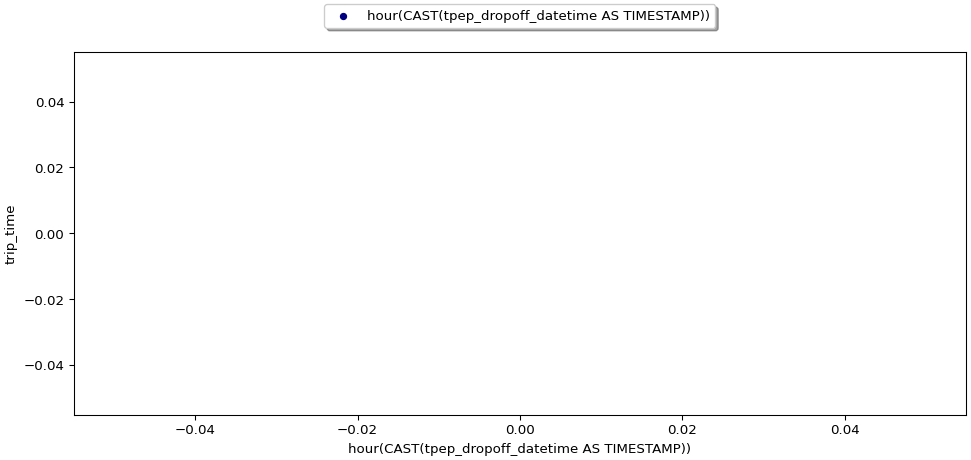

In [56]:
display(jfk_trip_times_by_hour_df)